In [2]:
from cv2 import face
recognizer = face.LBPHFaceRecognizer_create()

In [3]:
import cv2
import pandas as pd
import numpy as np
import sqlite3
import threading
import time
import os
import tkinter as tk
from tkinter import ttk, messagebox
from datetime import datetime

### ---------------------- Database Functions ---------------------- ###
def create_database(db_name="attendance.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Users (
        user_id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT UNIQUE NOT NULL
    )
    """)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Attendance (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_id INTEGER,
        date TEXT,
        time TEXT,
        FOREIGN KEY(user_id) REFERENCES Users(user_id)
    )
    """)
    conn.commit()
    conn.close()
    print("Database and tables created successfully.")

def add_user_to_db(name, db_name="attendance.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    try:
        cursor.execute("INSERT INTO Users (name) VALUES (?)", (name,))
        conn.commit()
        user_id = cursor.lastrowid
        print(f"User '{name}' added with ID: {user_id}")
    except sqlite3.IntegrityError:
        cursor.execute("SELECT user_id FROM Users WHERE name = ?", (name,))
        user_id = cursor.fetchone()[0]
        print(f"User '{name}' already exists with ID: {user_id}")
    conn.close()
    return user_id

def log_attendance_db(user_id, db_name="attendance.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    current_date = datetime.now().strftime("%Y-%m-%d")
    current_time = datetime.now().strftime("%H:%M:%S")
    cursor.execute("INSERT INTO Attendance (user_id, date, time) VALUES (?, ?, ?)",
                   (user_id, current_date, current_time))
    conn.commit()
    conn.close()
    print(f"Attendance logged for user ID {user_id} at {current_date} {current_time}")

# Initialize the database (run once at start)
create_database()

### ---------------------- Face Recognition Setup ---------------------- ###
# Load the trained LBPH model and label mapping
model_filename = "trained_model.yml"
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read(model_filename)

# Read label map CSV. Expected format: Label,UserID
label_map_df = pd.read_csv("label_map.csv")
inv_label_map = {row['Label']: row['UserID'] for index, row in label_map_df.iterrows()}

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
if face_cascade.empty():
    raise IOError("Cannot load cascade file. Check the file path.")

### ---------------------- Global Variables ---------------------- ###
stop_event = threading.Event()
attendance_recorded = set()  # To avoid duplicate logging

### ---------------------- Face Recognition Thread ---------------------- ###
def run_recognition(auto_shutdown_delay=60):
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    
    while not stop_event.is_set():
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in faces:
            face_roi = gray_frame[y:y+h, x:x+w]
            label, confidence = recognizer.predict(face_roi)
            # Lower confidence implies a better match (typically below 100)
            if confidence < 100:
                name = inv_label_map.get(label, "Unknown")
            else:
                name = "Unknown"

            if name != "Unknown" and name not in attendance_recorded:
                # First, ensure the user exists in the DB (insert if needed)
                user_id = add_user_to_db(name)
                log_attendance_db(user_id)
                # Update the attendance log in the GUI
                current_time = datetime.now()
                attendance_entry = (name,
                                    current_time.strftime("%Y-%m-%d"),
                                    current_time.strftime("%H:%M:%S"))
                gui_add_attendance(attendance_entry)
                attendance_recorded.add(name)
                print("Attendance logged:", attendance_entry)
        
        # Auto shutdown after delay
        if time.time() - start_time > auto_shutdown_delay:
            print("Auto shutdown delay reached. Stopping recognition...")
            break

        # Small delay to reduce CPU usage
        time.sleep(0.1)

    cap.release()
    print("Recognition thread finished.")

### ---------------------- Tkinter GUI Functions ---------------------- ###
def start_recognition():
    stop_event.clear()
    # Start recognition in a daemon thread so it closes with the main app
    thread = threading.Thread(target=run_recognition, args=(60,), daemon=True)
    thread.start()
    messagebox.showinfo("Info", "Recognition started.")

def stop_recognition():
    stop_event.set()
    messagebox.showinfo("Info", "Recognition stopped.")

def gui_add_attendance(entry):
    # Insert a new row into the treeview widget in a thread-safe way
    attendance_tree.insert("", "end", values=entry)

def refresh_attendance():
    # In a more complete solution, you might re-read from the database.
    # For now, this function simply clears and updates the treeview.
    for row in attendance_tree.get_children():
        attendance_tree.delete(row)
    # Optionally, query the Attendance table to re-populate the tree.
    conn = sqlite3.connect("attendance.db")
    cursor = conn.cursor()
    cursor.execute("""
    SELECT U.name, A.date, A.time FROM Attendance A 
    JOIN Users U ON A.user_id = U.user_id
    ORDER BY A.id ASC
    """)
    records = cursor.fetchall()
    conn.close()
    for rec in records:
        attendance_tree.insert("", "end", values=rec)

def save_attendance():
    # Save attendance data from the database to an Excel file
    conn = sqlite3.connect("attendance.db")
    df = pd.read_sql_query("""
    SELECT U.name, A.date, A.time FROM Attendance A 
    JOIN Users U ON A.user_id = U.user_id
    ORDER BY A.id ASC
    """, conn)
    conn.close()
    filename = "attendance_recognition_gui.xlsx"
    df.to_excel(filename, index=False)
    messagebox.showinfo("Info", f"Attendance saved to {filename}")

### ---------------------- Tkinter GUI Setup ---------------------- ###
root = tk.Tk()
root.title("Face Recognition Attendance System")
root.geometry("700x500")

# Frame for control buttons
btn_frame = tk.Frame(root)
btn_frame.pack(pady=10)

start_btn = tk.Button(btn_frame, text="Start Recognition", command=start_recognition)
start_btn.pack(side="left", padx=5)

stop_btn = tk.Button(btn_frame, text="Stop Recognition", command=stop_recognition)
stop_btn.pack(side="left", padx=5)

refresh_btn = tk.Button(btn_frame, text="Refresh Attendance", command=refresh_attendance)
refresh_btn.pack(side="left", padx=5)

save_btn = tk.Button(btn_frame, text="Save Attendance", command=save_attendance)
save_btn.pack(side="left", padx=5)

# Attendance table using ttk Treeview
attendance_tree = ttk.Treeview(root, columns=("Name", "Date", "Time"), show="headings", height=15)
attendance_tree.heading("Name", text="Name")
attendance_tree.heading("Date", text="Date")
attendance_tree.heading("Time", text="Time")
attendance_tree.column("Name", width=200)
attendance_tree.column("Date", width=150)
attendance_tree.column("Time", width=150)
attendance_tree.pack(pady=10, fill="both", expand=True)

root.mainloop()

Database and tables created successfully.
User 'Atharv' added with ID: 1
Attendance logged for user ID 1 at 2025-03-02 23:03:10
Attendance logged: ('Atharv', '2025-03-02', '23:03:10')
Recognition thread finished.


In [4]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("attendance.db")

# Load attendance records into a DataFrame
df = pd.read_sql_query("SELECT * FROM Attendance", conn)

# Close connection
conn.close()

# Display the first few rows
df.head()


,id,user_id,date,time
0,1,1,2025-03-02,23:03:10


C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


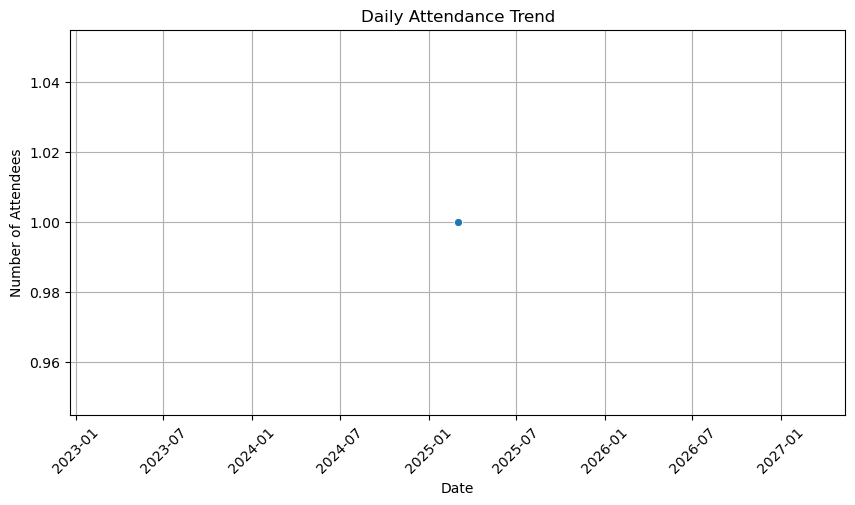

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Count attendance per day
daily_attendance = df.groupby('date').size()

# Plot attendance trends
plt.figure(figsize=(10, 5))
sns.lineplot(x=daily_attendance.index, y=daily_attendance.values, marker="o")

plt.xlabel("Date")
plt.ylabel("Number of Attendees")
plt.title("Daily Attendance Trend")
plt.xticks(rotation=45)
plt.grid()

plt.show()


C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


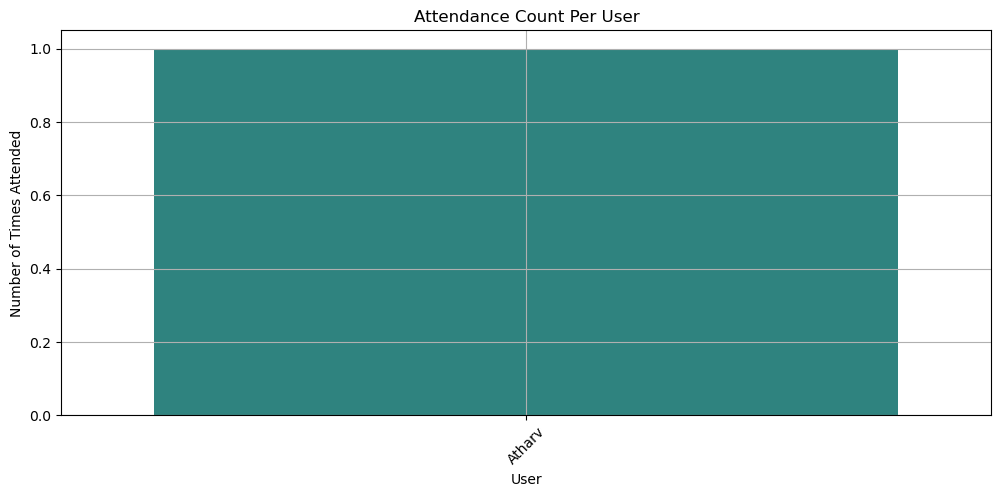

In [6]:
# Load user mapping
user_df = pd.read_sql_query("SELECT * FROM Users", sqlite3.connect("attendance.db"))

# Merge attendance data with user names
df_merged = df.merge(user_df, left_on="user_id", right_on="user_id", how="left")

# Count attendance per user
user_attendance = df_merged['name'].value_counts()

# Plot attendance per user
plt.figure(figsize=(12, 5))
sns.barplot(x=user_attendance.index, y=user_attendance.values, palette="viridis")

plt.xlabel("User")
plt.ylabel("Number of Times Attended")
plt.title("Attendance Count Per User")
plt.xticks(rotation=45)
plt.grid()

plt.show()


In [7]:
# Define threshold for low attendance
low_attendance_threshold = 2

# Find users with low attendance
low_attendees = user_attendance[user_attendance <= low_attendance_threshold]

print("Users with low attendance:")
print(low_attendees)

Users with low attendance:
name
Atharv    1
Name: count, dtype: int64


In [8]:
# Save attendance report to an Excel file
df_merged.to_excel("Attendance_Report.xlsx", index=False)

print("Attendance report saved as 'Attendance_Report.xlsx'")

Attendance report saved as 'Attendance_Report.xlsx'
